Actual Vs Predicted 

[INFO] Successfully loaded 'day.csv'
--------------------------------------------------
Mean Absolute Error (MAE): 299.42 bikes
--------------------------------------------------


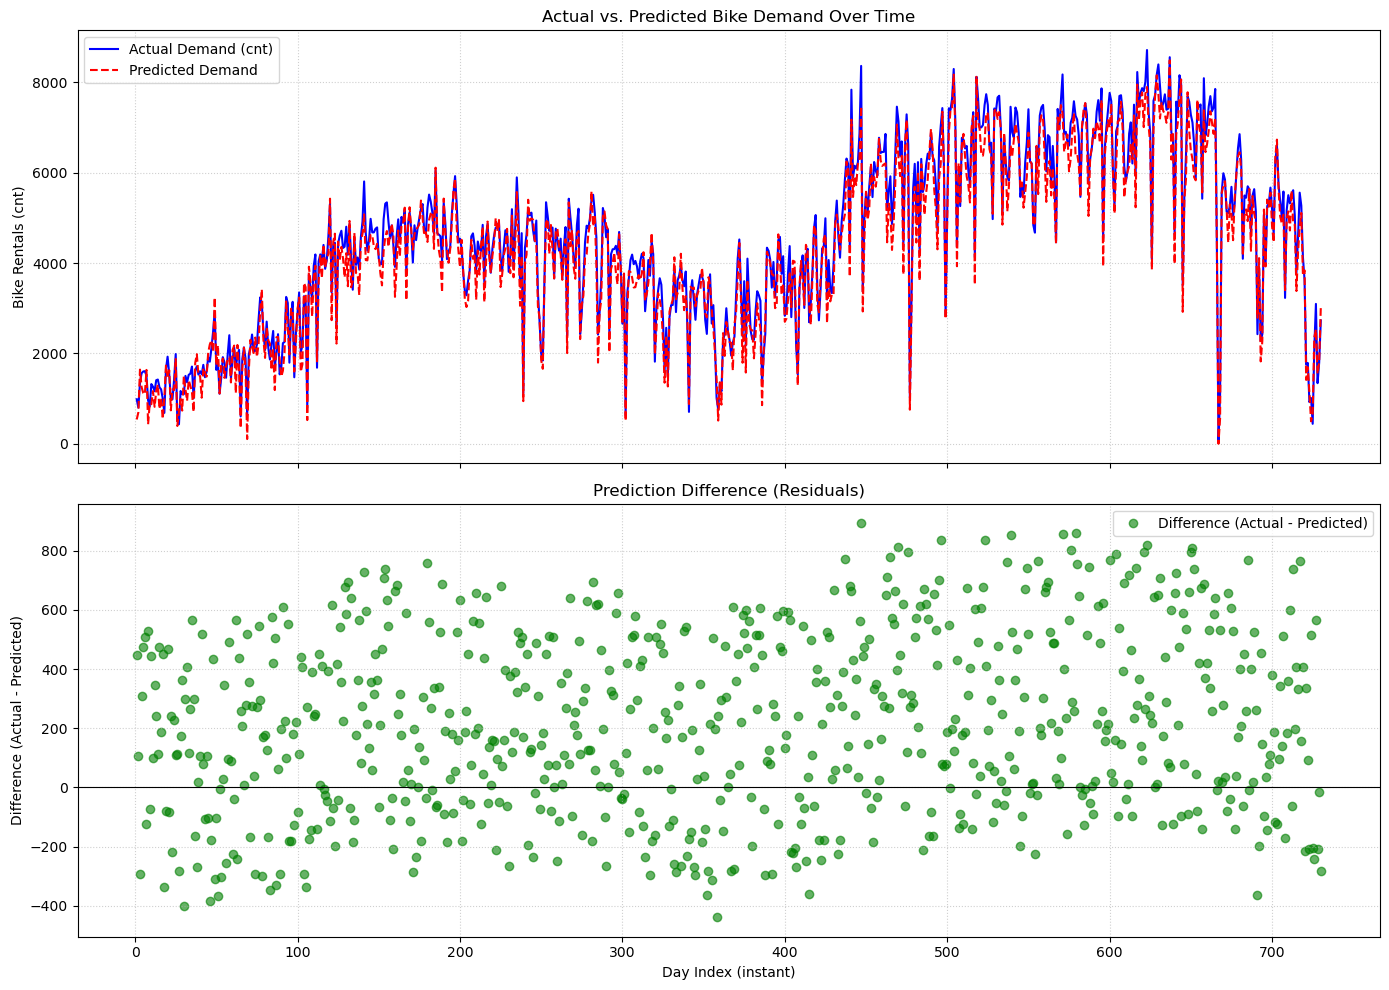

Saved comparison data to 'bike_demand_comparison_output_v2.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. Load the Data
df = None # Initialize df to handle potential FileNotFoundError
try:
    # IMPORTANT: Ensure 'day.csv' is in the same folder as this script!
    df = pd.read_csv(r"C:\Users\preet\Downloads\day.csv") 
# The 'r' before the quote creates a "raw string" which handles backslashes correctly.
    print("[INFO] Successfully loaded 'day.csv'")
except FileNotFoundError:
    print("FATAL ERROR: 'day.csv' not found. Please check your working directory or file path.")

# Proceed only if the DataFrame was loaded successfully
if df is not None:
    # Use 'cnt' as the actual values
    actual_cnt = df['cnt']

    # --- SIMULATE PREDICTIONS ---
    # NOTE: ***REPLACE THIS SECTION*** with the results from your trained model.
    # For example, if X_test is your test data and model is your trained model:
    # df['predicted_cnt'] = model.predict(X_test)
    np.random.seed(42)
    noise = np.random.randint(-500, 500, size=len(actual_cnt))
    df['predicted_cnt'] = (actual_cnt * 0.95 + noise).astype(int)
    df['predicted_cnt'] = df['predicted_cnt'].apply(lambda x: max(0, x))
    # ----------------------------

    # 2. Calculate Difference and Error Metric
    df['difference'] = df['cnt'] - df['predicted_cnt']
    mae = mean_absolute_error(df['cnt'], df['predicted_cnt'])

    print("-" * 50)
    print(f"Mean Absolute Error (MAE): {mae:.2f} bikes")
    print("-" * 50)

    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot 1: Actual vs. Predicted Time Series
    ax1.plot(df['instant'], df['cnt'], label='Actual Demand (cnt)', color='blue')
    ax1.plot(df['instant'], df['predicted_cnt'], label='Predicted Demand', color='red', linestyle='--')
    ax1.set_title('Actual vs. Predicted Bike Demand Over Time')
    ax1.set_ylabel('Bike Rentals (cnt)')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Plot 2: Difference (Residuals)
    ax2.scatter(df['instant'], df['difference'], label='Difference (Actual - Predicted)', color='green', alpha=0.6)
    ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax2.set_title('Prediction Difference (Residuals)')
    ax2.set_xlabel('Day Index (instant)')
    ax2.set_ylabel('Difference (Actual - Predicted)')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Optional: Save the comparison to a file
    comparison_df = df[['dteday', 'cnt', 'predicted_cnt', 'difference']]
    comparison_df.to_csv('bike_demand_comparison_output_v2.csv', index=False)
    print("Saved comparison data to 'bike_demand_comparison_output_v2.csv'")
else:
    print("Analysis aborted due to file loading error.")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Configuration & Model Setup (No change needed here)

# 2. Load and Prepare Data
df = None
try:
    # IMPORTANT: Ensure 'day.csv' is in the same folder as this script, 
    # OR replace 'day.csv' with your full absolute path: 
    # df = pd.read_csv(r"C:\Users\preet\Downloads\day.csv") 
    df = pd.read_csv(r"C:\Users\preet\Downloads\day.csv")
    
    # ... (Rest of the data preparation logic) ...
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x == 0 or x == 6 else 0)
    
    FEATURE_COLS = [
        'season', 'yr', 'mnth', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'hum',
        'windspeed', 'is_weekend'
    ]
    TARGET_COL = 'cnt'
    
    X = df[FEATURE_COLS]
    y = df[TARGET_COL]

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Define Models
    MODELS = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42)
    }
    
    # 5. Train, Predict, and Evaluate All Models
    results = {}
    
    for name, model in MODELS.items():
        # Train and Predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'Predictions': y_pred
        }

    # 6. Determine Best Model
    best_model_name = min(results, key=lambda k: results[k]['MAE'])
    best_predictions = results[best_model_name]['Predictions']

    print(f"BEST MODEL: {best_model_name} (MAE: {results[best_model_name]['MAE']:.2f})")
    
    # 7. Create Detailed Comparison CSV for the Best Model
    comparison_df = pd.DataFrame({
        'dteday': df.loc[y_test.index, 'dteday'], 
        'Actual_Count': y_test,
        'Predicted_Count': best_predictions.astype(int),
        'Difference (Residual)': y_test - best_predictions
    }).sort_index()
    
    # Save the output file
    comparison_df.to_csv(f'{best_model_name.replace(" ", "_").lower()}_test_set_comparison.csv', index=False)
    
except FileNotFoundError:
    print("\nFATAL ERROR: 'day.csv' not found. Please check your working directory or file path.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

BEST MODEL: Random Forest (MAE: 414.82)
